# **GA Error Sources**

In [52]:
path = os.getcwd().split("/")[:-2]
path = "/".join(path)
sys.path.append(path)

from ga_error_sources.model.normPSM import NormPSM
from ga_error_sources.model.gaModel import GAModel
from ga_error_sources.utils.plot_funcs import get_percentiles, custom_percentile_cmap, get_sticks
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import os
import sys

## **Initial Values of System**

- **M**: *int* = Num of sequences;
- **n_max**: *int* = Number of pairs in native arrangment, where n in {0, ..., M};
- **n_bins**: *int* = Number of intervals in I;
- **i_nat**: *float* = Value of i for native arrangment;
- **i_0**: *float* = I mean for arrangments with n = 0;
- **sigma2_0**: *float* = Variance of I for arrangments with n = 0;
- **n_step**: *int* = Max n transition in genetic algorithm.

In [53]:
M = 10
n_max = M + 1 
n_bins = M + 1 
i_nat = 14
i_0 = 4 
sigma2_0 = 0.1
n_step = 1

## **Protein System Model Instance**

In [54]:
sys_model = NormPSM(M, i_0, i_nat, sigma2_0, n_bins)

### Curves of the expected value of I and its variance.

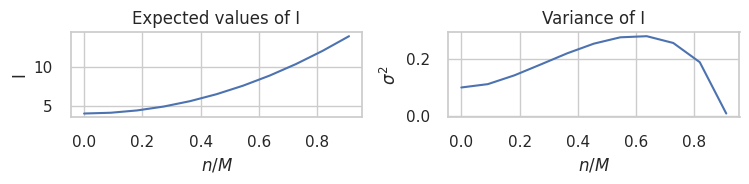

In [55]:
expecs = [sys_model.expec_ns(n) for n in range(n_max)]
sigmas2 = [sys_model.sigma2_ns(n) for n in range(n_max)]

normalized_ns = np.arange(n_max) / n_max

fig, axs = plt.subplots(1, 2, figsize=(7.8, 2))

axs[0].plot(normalized_ns, expecs)
axs[0].set_title("Expected values of I")
axs[0].set_xlabel(r"$n / M$")
axs[0].set_ylabel("I")

axs[1].plot(normalized_ns, sigmas2)
axs[1].set_title("Variance of I")
axs[1].set_xlabel(r"$n / M$")
axs[1].set_ylabel(r"$\sigma ^2$")

fig.tight_layout()
plt.show()

In [56]:
# Get PDFs and state probabilities of I considering only normal distribution
norm_pdfs, norm_probs = sys_model.get_prob_bins()

# Poisson weights for each n in M sequences
poisson_weights = sys_model.get_poisson_weights()

# Get state probabilities (n, I)
prob_arr = sys_model.get_probs()

# Reassess state probabilites (n, I) with p=0.25
r_prob_arr = sys_model.reassessment_probs(prob_arr, p=0.25)

## **Markov Model for Genetic Algorithm**

In [57]:
ga_model = GAModel()

# Construct transitions matrix from state probabilities:
transitions, indexes = ga_model.get_transitions_matrix(prob_arr)

# Most likely path of system I optimization in a genetic algorithm
init_state = list(np.unravel_index(np.argmax(prob_arr), prob_arr.shape))
path, step_probs = ga_model.get_best_path(prob_arr, minimize=False, init_state=init_state)

### Show path in GA (n,I) states

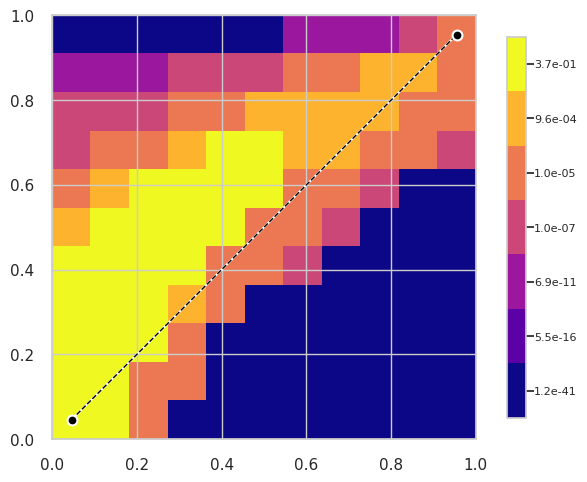

In [58]:
fig, axs = plt.subplots(1, 1)
cmap = custom_percentile_cmap

prob_arr_viz, value_map = get_percentiles(prob_arr)

c = axs.imshow(prob_arr_viz[::-1], extent=[0, 1, 0, 1], 
               cmap=cmap(len(value_map)),  interpolation='nearest') 

x_steps = [(x[1] / n_bins) + 0.5 * 1 / n_bins for x in path]
y_steps = [(y[0] / (n_max)) + 0.5 * 1 / (n_max) for y in path]

cbar = fig.colorbar(c, ax=axs, shrink=0.9)
cticks = get_sticks(len(value_map))
ctick_labels = [f"{x:.1e}" for x in value_map]
cbar.set_ticks(cticks)
cbar.set_ticklabels(ctick_labels)
cbar.ax.tick_params(labelsize=8, pad=0.08)

axs.plot(x_steps, y_steps, '-', lw=1.5, color='white', zorder=1)
axs.plot(x_steps, y_steps, '--', lw=1, color='black', zorder=2)
axs.scatter([x_steps[0], x_steps[-1]], [y_steps[0], y_steps[-1]], marker="o", 
             s=50, facecolors='black', edgecolors='white', linewidth=1.5, zorder=3, clip_on=False)

plt.show()